# LABORATORIO 1 - Detección de Pishing

OBJETIVOS
- Realizar una revisión de literatura para identificar características potenciales en las URLs de 
Phishing 
- Implementar un modelo de ML para clasificar si un dominio es legítimo o es Phishing

In [7]:
import pandas as pd
import numpy as np
import re, math
from urllib.parse import urlparse

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score,
    roc_curve, roc_auc_score
)
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import matplotlib.pyplot as plt

## Exploración de datos

In [8]:
DATASET_PATH = "dataset_pishing.csv"

URL_COL = "url"
LABEL_COL = "status"

df_raw = pd.read_csv(DATASET_PATH)

print("Shape:", df_raw.shape)
print("Columns:", df_raw.columns.tolist())
df_raw.head()

Shape: (11430, 2)
Columns: ['url', 'status']


,url,status
0,http://www.crestonwood.com/router.php,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,phishing
2,https://support-appleld.com.secureupdate.duila...,phishing
3,http://rgipt.ac.in,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,legitimate


In [9]:
df_raw.sample(5, random_state=42)

,url,status
7529,https://www.rga.com/about/workplace,legitimate
11221,http://starasia.com.hk,legitimate
4889,https://www.youtube.com/watch?v=XszqITK-UEw,legitimate
8962,http://www.civico1845.com/,legitimate
4004,http://rapidpaws.com/wp-content/we_transfer/in...,phishing


In [10]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11430 entries, 0 to 11429
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   url     11430 non-null  object
 1   status  11430 non-null  object
dtypes: object(2)
memory usage: 178.7+ KB


In [11]:

df_raw[LABEL_COL].value_counts(dropna=False)

status
legitimate    5715
phishing      5715
Name: count, dtype: int64

In [12]:

df_raw[LABEL_COL].value_counts(normalize=True, dropna=False)

status
legitimate    0.5
phishing      0.5
Name: proportion, dtype: float64

## Derivación de características

In [13]:
def safe_parse(url: str):
    if not isinstance(url, str):
        url = str(url)
    url = url.strip()

    if not re.match(r"^[a-zA-Z][a-zA-Z0-9+.-]*://", url):
        url_for_parse = "http://" + url
    else:
        url_for_parse = url

    p = urlparse(url_for_parse)
    host = p.netloc or ""

    if "@" in host:
        host = host.split("@", 1)[1]

    hostname = host.split(":", 1)[0]
    port = None
    if ":" in host:
        try:
            port = int(host.split(":", 1)[1])
        except:
            port = None

    return p, hostname, port


def is_ip(hostname: str) -> int:
    if not hostname:
        return 0
    return 1 if re.match(r"^(\d{1,3}\.){3}\d{1,3}$", hostname) else 0


def shannon_entropy(s: str) -> float:
    if not s:
        return 0.0
    counts = {}
    for ch in s:
        counts[ch] = counts.get(ch, 0) + 1
    # print(f"{counts}")
    n = len(s)
    ent = 0.0
    for c in counts.values():
        p = c / n
        ent -= p * math.log(p, 2)
        # print(f"{ent}")
    return float(ent)


def nan_entropy(url: str) -> float:
    if not url:
        return 0.0
    nan_chars = [ch for ch in url if not ch.isalnum()]
    if not nan_chars:
        return 0.0
    counts = {}
    for ch in nan_chars:
        counts[ch] = counts.get(ch, 0) + 1
    n = len(nan_chars)
    ent = 0.0
    for c in counts.values():
        p = c / n
        ent -= p * math.log(p, 2)
        # print(f"{ent}")
    return float(ent)



def build_reference_distribution_from_series(url_series: pd.Series) -> dict:
    counts = {}
    total = 0
    for url in url_series.dropna().astype(str).values:
        for ch in url:
            counts[ch] = counts.get(ch, 0) + 1
            total += 1
    if total == 0:
        return {}
    return {ch: c/total for ch, c in counts.items()}


def kl_divergence_char_dist(s: str, reference: dict, eps: float = 1e-12) -> float:
    if not s:
        return 0.0
    counts = {}
    for ch in s:
        counts[ch] = counts.get(ch, 0) + 1
    n = len(s)
    kl = 0.0
    for ch, c in counts.items():
        p = c / n
        q = max(reference.get(ch, 0.0), eps)
        # print(f"{q}")
        kl += p * math.log(p / q, 2)
    return float(kl)


In [14]:
def encode_status(s: str) -> int:
    s = str(s).strip().lower()
    if s in ["phishing", "pishing"]:
        return 1
    if s in ["legitimate", "legit"]:
        return 0
    return np.nan

tmp_y = df_raw[LABEL_COL].apply(encode_status)
df_tmp = df_raw.copy()
df_tmp["y"] = tmp_y
df_tmp = df_tmp.dropna(subset=["y"])

REFERENCE_CHAR_DISTRIBUTION = build_reference_distribution_from_series(
    df_tmp.loc[df_tmp["y"] == 0, URL_COL]  # legit only
)

print("Reference distribution size:", len(REFERENCE_CHAR_DISTRIBUTION))
list(REFERENCE_CHAR_DISTRIBUTION.items())[:10]

Reference distribution size: 79


[('h', 0.03743929685913178),
 ('t', 0.08556234651106967),
 ('p', 0.04124305260631128),
 (':', 0.021223479882563658),
 ('/', 0.08090920841257825),
 ('w', 0.05265062688110494),
 ('.', 0.04637258341488635),
 ('c', 0.040685414627841275),
 ('r', 0.04120981590560777),
 ('e', 0.06215632328230884)]

In [15]:
SENSITIVE_WORDS = [
    "confirm","account","bank","banking","secure","login","signin","update","verify","password","wallet","billing"
]

SHORTENER_DOMAINS = [
    "bit.ly","tinyurl.com","t.co","goo.gl","ow.ly","is.gd","buff.ly","cutt.ly","rb.gy","shorturl.at"
]

def extract_features(url: str) -> dict:
    url = str(url)
    p, hostname, port = safe_parse(url)
    path = p.path or ""
    query = p.query or ""
    scheme = (p.scheme or "").lower()

    url_lower = url.lower()
    host_lower = (hostname or "").lower()

    url_len = len(url_lower)
    host_len = len(host_lower)
    path_len = len(path)
    query_len = len(query)

    dots = host_lower.count(".")
    hyphens = host_lower.count("-")
    subdomain_count = max(dots - 1, 0)
    tld = host_lower.split(".")[-1] if "." in host_lower else ""
    tld_len = len(tld)

    n_digits = sum(ch.isdigit() for ch in url_lower)
    n_letters = sum(ch.isalpha() for ch in url_lower)
    n_special = sum((not ch.isalnum()) for ch in url_lower)

    has_at = 1 if "@" in url_lower else 0
    has_ip_flag = is_ip(host_lower)
    has_https = 1 if url_lower.startswith("https://") else 0
    has_http = 1 if url_lower.startswith("http://") else 0
    double_slash_in_path = 1 if "//" in (p.path or "") else 0
    has_port = 1 if port is not None else 0
    num_query_params = 0 if not query else query.count("&") + 1

    is_shortened = 1 if host_lower in SHORTENER_DOMAINS else 0
    has_sensitive_words = 1 if any(w in url_lower for w in SENSITIVE_WORDS) else 0

    ent_url = shannon_entropy(url_lower)
    ent_domain = shannon_entropy(host_lower)
    ent_nan = nan_entropy(url_lower)
    rel_ent = kl_divergence_char_dist(url_lower, REFERENCE_CHAR_DISTRIBUTION)

    return {
        "url_length": url_len,
        "hostname_length": host_len,
        "path_length": path_len,
        "query_length": query_len,
        "num_dots": dots,
        "num_subdomains": subdomain_count,
        "num_hyphens": hyphens,
        "tld_length": tld_len,
        "count_digits": n_digits,
        "count_letters": n_letters,
        "count_special": n_special,


        "ratio_digits": n_digits / url_len if url_len else 0.0,
        "ratio_special": n_special / url_len if url_len else 0.0,
        "has_at": has_at,
        "has_ip": has_ip_flag,
        "has_https": has_https,
        "has_http": has_http,
        "has_port": has_port,
        "double_slash_in_path": double_slash_in_path,
        "num_query_params": num_query_params,
        "is_shortened": is_shortened,
        "has_sensitive_words": has_sensitive_words,
        "shannon_entropy_url": ent_url,
        "shannon_entropy_domain": ent_domain,
        "nan_entropy": ent_nan,
        "relative_entropy_kl": rel_ent,
    }


In [16]:
features = df_raw[URL_COL].astype(str).apply(extract_features)
df_feat = pd.DataFrame(list(features))
df_feat[LABEL_COL] = df_raw[LABEL_COL].astype(str)

print("Engineered shape:", df_feat.shape)
df_feat.head()


Engineered shape: (11430, 27)


,url_length,hostname_length,path_length,query_length,num_dots,num_subdomains,num_hyphens,tld_length,count_digits,count_letters,...,has_port,double_slash_in_path,num_query_params,is_shortened,has_sensitive_words,shannon_entropy_url,shannon_entropy_domain,nan_entropy,relative_entropy_kl,status
0,37,19,11,0,2,1,0,3,0,30,...,0,0,0,0,0,3.787043,3.195296,1.448816,0.566062,legitimate
1,77,23,47,0,1,0,0,3,17,53,...,0,0,0,0,0,4.393890,3.708132,1.148835,0.947889,phishing
2,126,50,20,47,4,3,1,3,19,88,...,0,0,3,0,1,4.753412,3.999080,2.755058,0.882389,phishing
3,18,11,0,0,2,1,0,2,0,13,...,0,0,0,0,0,3.461320,3.095795,1.521928,0.959999,legitimate
4,55,15,33,0,2,1,0,3,0,45,...,0,0,0,0,0,4.097662,3.189898,1.760964,0.415933,legitimate


## Preprocesamiento

In [17]:
df_model = df_feat.copy()

df_model["y"] = df_model[LABEL_COL].apply(encode_status)
df_model = df_model.dropna(subset=["y"]).copy()
df_model["y"] = df_model["y"].astype(int)

df_model.drop(columns=[LABEL_COL], inplace=True)

dups = df_model.duplicated().sum()
print("Duplicate rows:", dups)
df_model = df_model.drop_duplicates().reset_index(drop=True)

df_model.head()


Duplicate rows: 9


,url_length,hostname_length,path_length,query_length,num_dots,num_subdomains,num_hyphens,tld_length,count_digits,count_letters,...,has_port,double_slash_in_path,num_query_params,is_shortened,has_sensitive_words,shannon_entropy_url,shannon_entropy_domain,nan_entropy,relative_entropy_kl,y
0,37,19,11,0,2,1,0,3,0,30,...,0,0,0,0,0,3.787043,3.195296,1.448816,0.566062,0
1,77,23,47,0,1,0,0,3,17,53,...,0,0,0,0,0,4.393890,3.708132,1.148835,0.947889,1
2,126,50,20,47,4,3,1,3,19,88,...,0,0,3,0,1,4.753412,3.999080,2.755058,0.882389,1
3,18,11,0,0,2,1,0,2,0,13,...,0,0,0,0,0,3.461320,3.095795,1.521928,0.959999,0
4,55,15,33,0,2,1,0,3,0,45,...,0,0,0,0,0,4.097662,3.189898,1.760964,0.415933,0


## Selección de Características

In [18]:
X_all = df_model.drop(columns=["y"])
y_all = df_model["y"]

nunique = X_all.nunique()
constant_cols = nunique[nunique <= 1].index.tolist()
print("Constant:", constant_cols)

X_sel = X_all.drop(columns=constant_cols).copy()
print(X_sel.shape)

Constant: []
(11421, 26)


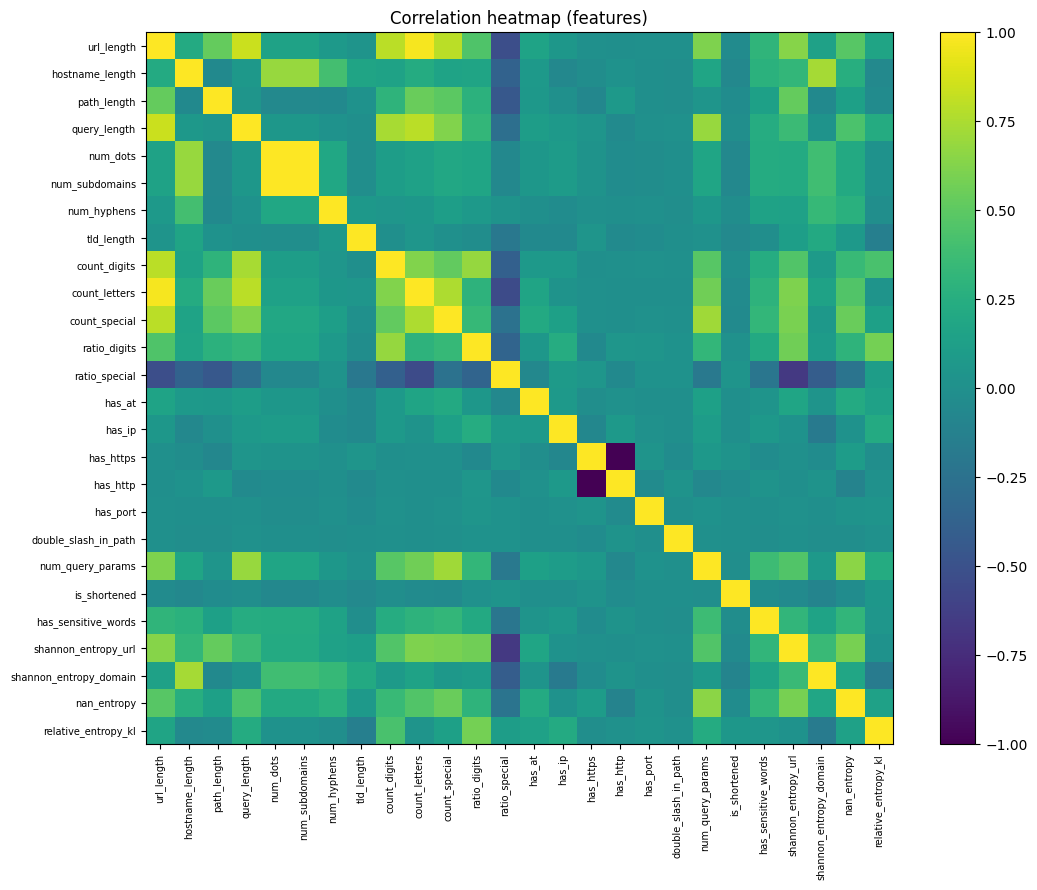

In [19]:
corr = X_sel.corr(numeric_only=True)

plt.figure(figsize=(11, 9))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.title("Correlation heatmap (features)")
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=7)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=7)
plt.tight_layout()
plt.show()

In [20]:
THRESH = 0.92
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))
to_drop_corr = [c for c in upper.columns if any(upper[c].abs() > THRESH)]
print("Highly correlated drop list:", to_drop_corr)

X_final = X_sel.drop(columns=to_drop_corr).copy()
print("Final feature count:", X_final.shape[1])
X_final.columns.tolist()

Highly correlated drop list: ['num_subdomains', 'count_letters', 'has_http']
Final feature count: 23


['url_length',
 'hostname_length',
 'path_length',
 'query_length',
 'num_dots',
 'num_hyphens',
 'tld_length',
 'count_digits',
 'count_special',
 'ratio_digits',
 'ratio_special',
 'has_at',
 'has_ip',
 'has_https',
 'has_port',
 'double_slash_in_path',
 'num_query_params',
 'is_shortened',
 'has_sensitive_words',
 'shannon_entropy_url',
 'shannon_entropy_domain',
 'nan_entropy',
 'relative_entropy_kl']

## Separación de datos

In [21]:
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_final, y_all, test_size=0.30, random_state=42, stratify=y_all
)

val_ratio_inside = 15/70
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=val_ratio_inside, random_state=42, stratify=y_trainval
)

print("Train:", X_train.shape, "Val:", X_val.shape, "Test:", X_test.shape)


Train: (6281, 23) Val: (1713, 23) Test: (3427, 23)


In [22]:
train_out = X_train.copy(); train_out["y"] = y_train.values
val_out   = X_val.copy();   val_out["y"]   = y_val.values
test_out  = X_test.copy();  test_out["y"]  = y_test.values

train_out.to_csv("train_55.csv", index=False)
val_out.to_csv("val_15.csv", index=False)
test_out.to_csv("test_30.csv", index=False)

## Implementación
* Random Forest y Gradient Boosting

In [23]:
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced_subsample"
)

gb = GradientBoostingClassifier(random_state=42)

rf.fit(X_train, y_train)
gb.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [24]:
def evaluate_model(model, X_eval, y_eval, name="model", threshold=0.5):
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X_eval)[:, 1]
    else:
        proba = model.decision_function(X_eval)
        proba = (proba - proba.min()) / (proba.max() - proba.min() + 1e-12)

    pred = (proba >= threshold).astype(int)

    cm = confusion_matrix(y_eval, pred)
    prec = precision_score(y_eval, pred, zero_division=0)
    rec = recall_score(y_eval, pred, zero_division=0)
    auc = roc_auc_score(y_eval, proba)

    fpr, tpr, _ = roc_curve(y_eval, proba)

    print(f"\n=== {name} @ thr={threshold:.2f} ===")
    print("Confusion matrix [[TN FP],[FN TP]]:")
    print(cm)
    print(f"Precision: {prec:.4f}")
    print(f"Recall:    {rec:.4f}")
    print(f"AUC:       {auc:.4f}")

    plt.figure()
    plt.plot(fpr, tpr, label=f"{name} (AUC={auc:.3f})")
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC — {name}")
    plt.legend()
    plt.show()

    return {"name": name, "cm": cm, "precision": prec, "recall": rec, "auc": auc}



=== Random Forest (val) @ thr=0.50 ===
Confusion matrix [[TN FP],[FN TP]]:
[[755 102]
 [ 97 759]]
Precision: 0.8815
Recall:    0.8867
AUC:       0.9491


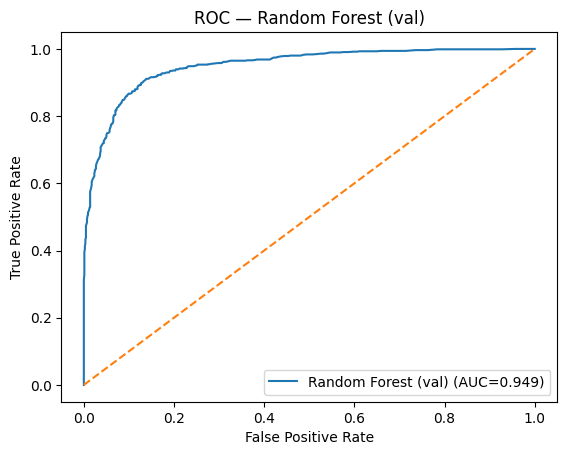


=== Gradient Boosting (val) @ thr=0.50 ===
Confusion matrix [[TN FP],[FN TP]]:
[[751 106]
 [139 717]]
Precision: 0.8712
Recall:    0.8376
AUC:       0.9315


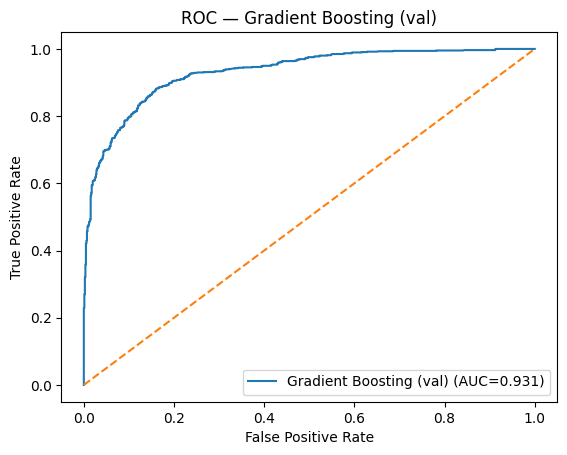

({'name': 'Random Forest (val)',
  'cm': array([[755, 102],
         [ 97, 759]]),
  'precision': 0.8815331010452961,
  'recall': 0.8866822429906542,
  'auc': 0.9490568326808361},
 {'name': 'Gradient Boosting (val)',
  'cm': array([[751, 106],
         [139, 717]]),
  'precision': 0.8712029161603888,
  'recall': 0.8376168224299065,
  'auc': 0.9314762156621119})

In [25]:
rf_val = evaluate_model(rf, X_val, y_val, name="Random Forest (val)")
gb_val = evaluate_model(gb, X_val, y_val, name="Gradient Boosting (val)")

rf_val, gb_val



=== Random Forest (test) @ thr=0.50 ===
Confusion matrix [[TN FP],[FN TP]]:
[[1484  231]
 [ 232 1480]]
Precision: 0.8650
Recall:    0.8645
AUC:       0.9433


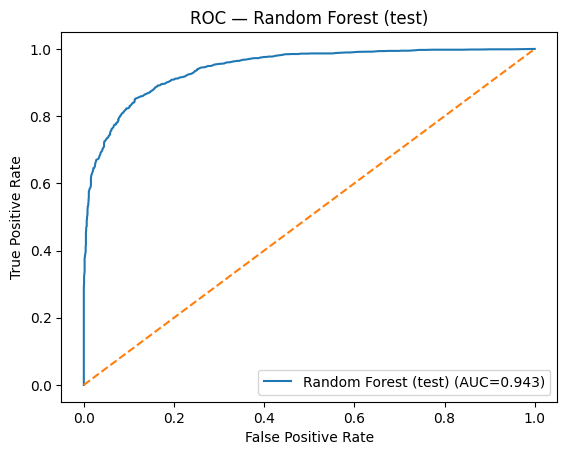


=== Gradient Boosting (test) @ thr=0.50 ===
Confusion matrix [[TN FP],[FN TP]]:
[[1501  214]
 [ 307 1405]]
Precision: 0.8678
Recall:    0.8207
AUC:       0.9278


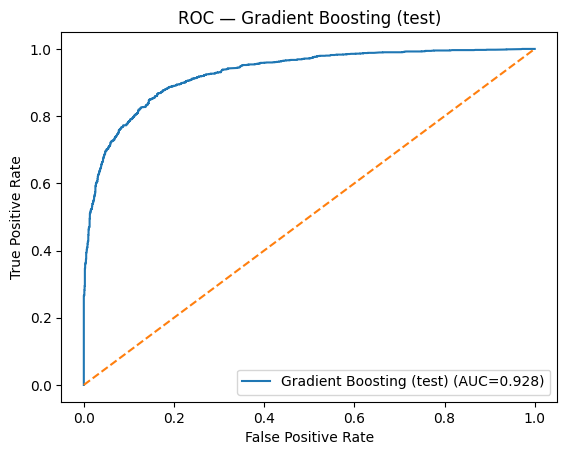

({'name': 'Random Forest (test)',
  'cm': array([[1484,  231],
         [ 232, 1480]]),
  'precision': 0.8649912331969608,
  'recall': 0.8644859813084113,
  'auc': 0.9433009318547178},
 {'name': 'Gradient Boosting (test)',
  'cm': array([[1501,  214],
         [ 307, 1405]]),
  'precision': 0.8678196417541693,
  'recall': 0.820677570093458,
  'auc': 0.927848355630637})

In [26]:
rf_test = evaluate_model(rf, X_test, y_test, name="Random Forest (test)")
gb_test = evaluate_model(gb, X_test, y_test, name="Gradient Boosting (test)")

rf_test, gb_test

## Discusión

1. ¿Cuál es el impacto de clasificar un sitio legítimo como phishing?  
- El oscurecimiento y bloqueo de fuentes de información y servicios legítimos. Este tipo de eventos reduce la visibilidad de sitios funcionales.

2. ¿Cuál es el impacto de clasificar un sitio de phishing como legítimo? 
- Aumentar la visibilidad y probabilidad de impacto de un intento de phishing, aumentando el nivel de exposición del público general.


3. En base a las respuestas anteriores, ¿Qué métrica elegiría para comparar modelos similares de clasificación de phishing?  
- Dado que el costo de un FN (dejar pasar phishing) normalmente es mayor que el de un FP, priorizaría. Para comparar de forma robusta usola matriz de confusión para asegurar FN bajos.

4. ¿Qué modelo funcionó mejor para la clasificación de phishing? ¿Por qué?  
- Basado en validación, el modelo seleccionado fue Random Forest. Métricas: AUC=0.9491, Recall=0.8867, Precision=0.8815.


5. Una empresa desea utilizar su mejor modelo, debido a que sus empleados sufren constantes ataques de phishing mediante e-mail. La empresa estima que, de un total de 50000 emails, un 15% son phishing. ¿Qué cantidad de alarmas generaría su modelo? ¿Cuántas positivas y cuantas  negativas?  ¿Funciona  el  modelo  para  el  BR  propuesto?  En  caso  negativo,  ¿qué propone para reducir la cantidad de falsas alarmas? 

In [ ]:
DEBUG = True

def _get(d, k, default=None):
    try:
        return d.get(k, default)
    except Exception:
        return default

def cm_to_rates(cm):
    tn, fp, fn, tp = cm.ravel()
    tpr = tp / (tp + fn) if (tp + fn) else 0.0
    fpr = fp / (fp + tn) if (fp + tn) else 0.0
    tnr = tn / (tn + fp) if (tn + fp) else 0.0
    fnr = fn / (fn + tp) if (fn + tp) else 0.0
    return {"tn": tn, "fp": fp, "fn": fn, "tp": tp, "tpr": tpr, "fpr": fpr, "tnr": tnr, "fnr": fnr}

def pick_best_by_validation(rf_val, gb_val):
    cand = [rf_val, gb_val]
    cand = [c for c in cand if c is not None]
    best = sorted(cand, key=lambda d: (_get(d, "auc", 0.0), _get(d, "recall", 0.0)), reverse=True)[0]
    return best

best_val = pick_best_by_validation(rf_val, gb_val)

if DEBUG:
    print("[DEBUG] best_val:", best_val["name"], "AUC=", best_val["auc"], "Recall=", best_val["recall"], "Precision=", best_val["precision"])

if "Random Forest" in best_val["name"]:
    chosen_name = "Random Forest"
    chosen_test = rf_test
else:
    chosen_name = "Gradient Boosting"
    chosen_test = gb_test

cm_test = chosen_test["cm"]
rates = cm_to_rates(cm_test)

if DEBUG:
    print("[DEBUG] chosen_name:", chosen_name)
    print("[DEBUG] test CM:\n", cm_test)
    print("[DEBUG] rates:", rates)


N = 50_000
prevalence = 0.15
P = int(round(N * prevalence))
Nneg = N - P

TP = int(round(P * rates["tpr"]))
FN = P - TP
FP = int(round(Nneg * rates["fpr"]))
TN = Nneg - FP
ALARMS = TP + FP

if DEBUG:
    print("[DEBUG] Scenario computed:",
          {"P": P, "Nneg": Nneg, "TP": TP, "FN": FN, "FP": FP, "TN": TN, "ALARMS": ALARMS})

q5 = (
    "5) Escenario 50,000 emails con 15% phishing:\n"
    f"- Phishing reales: {P} | Legítimos reales: {Nneg}\n"
    f"- Usando tasas del modelo en test (Recall/TPR={rates['tpr']:.3f}, FPR={rates['fpr']:.3f}):\n"
    f"  - Alarmas totales (predicho phishing): {ALARMS}\n"
    f"    - Verdaderas Positivas (TP): {TP}\n"
    f"    - Falsas Positivas (FP): {FP}\n"
    f"  - No alarma (predicho legítimo): {TN + FN}\n"
    f"    - Verdaderas Negativas (TN): {TN}\n"
    f"    - Falsas Negativas (FN): {FN}\n"
    "- Si FP fuera excesivo, mitigación propuesta:\n"
    "  - Ajustar el umbral de decisión (subirlo) para reducir FP a costa de algo de Recall.\n"
    "  - Pipeline por etapas: URL-model como filtro barato + verificación adicional (reputación/edad/ASN) solo para casos borderline.\n"
    "  - Modo cuarentena: alertar/retener enlaces sospechosos y permitir liberación tras revisión.\n"
)

print(q5)


[DEBUG] best_val: Random Forest (val) AUC= 0.9490568326808361 Recall= 0.8866822429906542 Precision= 0.8815331010452961
[DEBUG] chosen_name: Random Forest
[DEBUG] test CM:
 [[1484  231]
 [ 232 1480]]
[DEBUG] rates: {'tn': np.int64(1484), 'fp': np.int64(231), 'fn': np.int64(232), 'tp': np.int64(1480), 'tpr': np.float64(0.8644859813084113), 'fpr': np.float64(0.1346938775510204), 'tnr': np.float64(0.8653061224489796), 'fnr': np.float64(0.13551401869158877)}
[DEBUG] Scenario computed: {'P': 7500, 'Nneg': 42500, 'TP': 6484, 'FN': 1016, 'FP': 5724, 'TN': 36776, 'ALARMS': 12208}
1) Impacto de clasificar un sitio legítimo como phishing (Falso Positivo):
- Genera fricción operativa: bloqueo de recursos válidos, tickets a soporte y pérdida de productividad.
- Daña la confianza del usuario en el sistema: aparece fatiga de alertas, y los usuarios aprenden a ignorarlas.
- En ambientes corporativos puede interrumpir flujos críticos (pagos, portales, proveedores) si el filtro es agresivo.

2) Impacto 